In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.models import model_from_json

In [4]:
df1 = pd.read_csv('rbc_open.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
df_input = df1[['Vix ewm', 'High/Close', 'Low/Close',
       'Vix Close', 'CAD Close', 'Spread', 'Volume Diff',
       'Return ewm', 'Vix return', 'TD return', 'Tsx return',
       'Return', 'Chaikin']]
df_input

,Vix ewm,High/Close,Low/Close,Vix Close,CAD Close,Spread,Volume Diff,Return ewm,Vix return,TD return,Tsx return,Return,Chaikin
Date,,,,,,,,,,,,,
2010-01-06,-0.017666,0.006325,-0.004156,19.160000,1.03190,0.372903,814500.0,-0.010025,-0.009819,-0.009845,0.004744,-0.007354,3.729000e+05
2010-01-07,-0.009368,0.002347,-0.008485,19.059999,1.03400,0.385765,-1284300.0,-0.002739,-0.005219,-0.008700,-0.004772,0.000904,-4.557000e+05
2010-01-08,-0.035652,0.005064,-0.004160,18.129999,1.02980,0.327897,-276000.0,-0.002117,-0.048793,-0.001253,0.005577,-0.001806,-3.658500e+05
2010-01-11,-0.033211,0.006885,-0.001993,17.549999,1.03380,0.315038,172300.0,-0.001911,-0.031991,0.007061,-0.000561,-0.001809,-9.677500e+04
2010-01-12,0.015520,0.000000,-0.012098,18.250000,1.03920,0.430770,243100.0,0.001658,0.039886,-0.001247,-0.010622,0.003443,7.316250e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-13,-0.032076,0.001566,-0.003316,22.209999,1.27077,0.530006,-872600.0,0.001913,-0.048007,-0.002540,-0.002841,0.000922,-9.105427e+05
2021-01-14,0.020525,0.005824,-0.003328,23.250000,1.26981,0.989998,2582300.0,-0.001696,0.046826,0.013269,0.001305,-0.003500,8.358786e+05
2021-01-15,0.038096,0.000553,-0.008303,24.340000,1.26477,0.959999,565300.0,0.000790,0.046882,-0.002381,-0.002734,0.002034,7.005893e+05


In [5]:
y = df1[["Pos"]]
y.head()

,Pos
Date,
2010-01-06,1
2010-01-07,0
2010-01-08,0
2010-01-11,1
2010-01-12,1


In [6]:
file_path = Path("rbc_model_posneg.json")
with open(file_path, "r") as json_file:
    model_json = json_file.read()
loaded_model = model_from_json(model_json)

file_path = "rbc_weights_posneg.h5"
loaded_model.load_weights(file_path)

In [7]:
split = int(0.7 * len(df1))

df = df1[split:]


df_test = df_input[split:]
df_test.shape

(815, 13)

In [8]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_input, y, test_size=0.3, random_state=42)

x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()


x_train_scaler.fit(x_train)
x_test_scaler.fit(x_test)


x_train = x_train_scaler.transform(x_train)
x_test = x_test_scaler.transform(df_test)

enc = OneHotEncoder()
enc.fit(y_train)

encoded_y_train = enc.transform(y_train).toarray()
encoded_y_test = enc.transform(y_test).toarray()

In [9]:
predicted = loaded_model.predict(x_test)
predicted = enc.inverse_transform(predicted).flatten().tolist()
df["tomo prediction"] = predicted

C:\Users\User\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
from sklearn.metrics import classification_report
print(classification_report(df.Pos, df["tomo prediction"]))

              precision    recall  f1-score   support

           0       0.66      0.19      0.29       364
           1       0.59      0.92      0.72       451

    accuracy                           0.60       815
   macro avg       0.62      0.56      0.51       815
weighted avg       0.62      0.60      0.53       815



In [11]:
from sklearn.metrics import classification_report
print(classification_report(df.Pos, df["tomo prediction"]))

              precision    recall  f1-score   support

           0       0.66      0.19      0.29       364
           1       0.59      0.92      0.72       451

    accuracy                           0.60       815
   macro avg       0.62      0.56      0.51       815
weighted avg       0.62      0.60      0.53       815



In [12]:
df = df[["Open", "tomo prediction", "Dividends"]]
df["Pos"] = df1["Pos"]
df["prediction"] = df["tomo prediction"].shift(1)
df["last"] = df["prediction"].shift(1)
df = df.dropna()
back_csv_data = df.to_csv('RBC_backtest.csv', index = True) 

In [13]:
dividends = df.Dividends.loc["2017":].cumsum()
dividends[-1]*100

1395.0

In [22]:
import math
capital = float(100)
pos = float(1)
neg = float(0)

def Backtest(capital, split, year):
    initial_capital = capital
    df1 = df.loc[year:]
    shares = math.floor((initial_capital/df1.iat[0,0]) * split)
    hold_shares = math.floor(initial_capital/df1.iat[0,0]) - shares
    capital = capital - ((df1.iat[0,0] * shares) + (df1.iat[0,0] * hold_shares))
    bnh_shares = math.floor(initial_capital/df1.iat[0,0])
    newshares = shares
    port = shares
    dividends = df.Dividends.loc[year:].cumsum()
    sells = 0
    buys = shares + hold_shares
    tradelist = []
        
    if split > 1:
        return "Split Invalid, Please Choose a number between 0 and 1 to determine how the % of your portfolio to be actively traded."
    
    elif year < "2017":
        return "We can only backtest back to 2017"
    
    elif capital < 0:
        return "Not Enough Starting Capital"
    
    else:
        for i, row in df1.iterrows():
            if row['prediction'] == 1.0 and row['last'] == 0.0:
                if capital > (row['Open'] * shares):
                    capital = capital - (row['Open'] * shares)
                    port = port + shares
                    buys = buys + shares
                    tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
                else: 
                    tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
        
            elif row['prediction'] == 0.0 and row['last'] == 1.0:
                if port >= shares:
                    capital = capital + (row['Open'] * shares)
                    port = port - shares
                    sells = sells + shares
                    tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
                elif port == 0:
                    tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
                else:
                    while port < newshares:
                        if port < newshares:
                            newshares = newshares - 1
                        elif port >= newshares:
                            capital = capital + (row['Open'] * newshares)
                            port = port - newshares
                            sells = sells + newshares
                            newshares = shares
                            tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
                            break
            else:
                tradelist.append((row["Open"] * port) + (row["Open"] * hold_shares) + capital)
            
        tport = round(capital + (port * df1.iat[-1,0]) + (hold_shares * df1.iat[-1,0] + (dividends[-1] * hold_shares)),2)
                
        df1["port"] = tradelist
        df1["Open2"] = df1["Open"] * bnh_shares
        
        df1.plot(y=["port", "Open2"], kind="line")
        plt.legend(["Our Strategy", "Buy and Hold Strategy"])
                
        treturn = round(((tport - initial_capital)/initial_capital) * 100, 2)
        shop = round(((df1.iat[-1,0] - df1.iat[0,0])/df1.iat[0,0]) * 100, 2)
        bnh_leftover = initial_capital - (df1.iat[0,0] * bnh_shares)
        bnh = round(((df1.iat[-1,0] * bnh_shares) + bnh_leftover + (dividends[-1] * bnh_shares)),2)
        bnh_per = round(((bnh - (initial_capital))/initial_capital)*100, 2)
        print(f"Your Total Return is {treturn}%")
        print("")
        print(f"Total Portfolio Value is ${tport}")
        print("")
        print(f"Portfolio Breakdown")
        print(f"Avail. Funds: ${round(capital,2)}")
        print(f"Shares Value: ${round((tport-capital),2)}")
        print("")
        print(f"RBC Return: {shop}%")
        print("-------------------------------------------")
        print(f"                        Return     Total")
        print(f"Our Strategy:            {treturn}%      {tport}")
        print(f"Buy and Hold Strategy:   {bnh_per}%      {bnh}")
        print(f"")
        print(f"-------------------------------------------")
        print(f"Buy Orders: {buys}")
        print(f"Sell Orders: {sells}")
        print(f"Total Trades: {buys+sells}")

C:\Users\User\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\User\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Your Total Return is 43.52%

Total Portfolio Value is $14351.84

Portfolio Breakdown
Avail. Funds: $658.08
Shares Value: $13693.76

RBC Return: 29.19%
-------------------------------------------
                        Return     Total
Our Strategy:            43.52%      14351.84
Buy and Hold Strategy:   45.65%      14564.67

-------------------------------------------
Buy Orders: 3364
Sell Orders: 3245
Total Trades: 6609


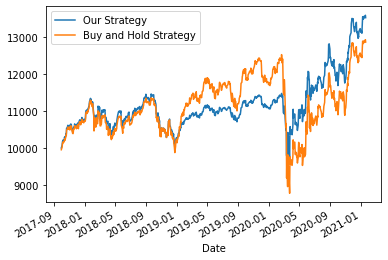

In [23]:
Backtest(10000,.5,'2017')